In [0]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/projects/fc-gaga'
LOGDIR = "logs"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/projects/fc-gaga


In [0]:
# from google_drive_downloader import GoogleDriveDownloader as gdd
# import pathlib

# gdd.download_file_from_google_drive(file_id='1pAGRfzMx6K9WWsfDcD1NMbIif0T0saFC', dest_path='data/metr-la.h5', unzip=False)
# gdd.download_file_from_google_drive(file_id='1wD-mHlqAb2mtHOe_68fZvDh1LpDegMMq', dest_path='data/pems-bay.h5', unzip=False)

# pathlib.Path('data/METR-LA').mkdir(parents=True, exist_ok=True)
# pathlib.Path('data/PEMS-BAY').mkdir(parents=True, exist_ok=True)
# !python generate_training_data_forwardfill.py --traffic_df_filename data/metr-la.h5 --output_dir data/METR-LA/  --horizon 12 --history_length 12
# !python generate_training_data_forwardfill.py --traffic_df_filename data/pems-bay.h5 --output_dir data/PEMS-BAY/  --horizon 12 --history_length 12


In [4]:
from typing import Dict, NamedTuple, Union

import time
import random
import tensorflow as tf
from dataset_pairwise import *
import matplotlib.pyplot as plt
import pandas as pd
print(tf.__version__)


from model import Trainer, Parameters
from model import hyperparams_defaults as hyperparams_dict

2.2.0


In [0]:
hyperparams = Parameters(**hyperparams_dict)

In [0]:
dataset = PemsDataset('data/METR-LA', hyperparams.batch_size, 
                      do_transform=False, speed_only=False,
                      horizon=hyperparams.horizon, history_length=hyperparams.history_length)

# dataset = PemsDataset('data/PEMS-BAY', hyperparams.batch_size, 
#                       do_transform=False, speed_only=False,
#                       horizon=hyperparams.horizon, history_length=hyperparams.history_length)


In [7]:
trainer = Trainer(hyperparams=hyperparams, logdir=LOGDIR)
trainer.fit(dataset=dataset)

Fitting model 1 out of 5, repeat=0;epochs=60;steps_per_epoch=800;num_stacks=3
Epoch 1/60


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


800/800 [==============================] - 31s 39ms/step - loss: 5.7302 - lr: 0.0010 - mae_val: 3.8510 - mae_test: 4.0821 - mae_val_h1: 3.0718 - mae_test_h1: 3.1099 - mape_val_h1: 7.7462 - rmse_val_h1: 4.8691 - mape_test_h1: 7.8698 - rmse_test_h1: 4.9687 - mae_val_h2: 3.1944 - mae_test_h2: 3.3221 - mape_val_h2: 8.3730 - rmse_val_h2: 5.4972 - mape_test_h2: 8.6396 - rmse_test_h2: 5.7233 - mae_val_h3: 3.1369 - mae_test_h3: 3.3685 - mape_val_h3: 8.5736 - rmse_val_h3: 5.8930 - mape_test_h3: 9.0358 - rmse_test_h3: 6.1986 - mae_val_h4: 3.5773 - mae_test_h4: 3.7578 - mape_val_h4: 9.8116 - rmse_val_h4: 6.4998 - mape_test_h4: 10.1648 - rmse_test_h4: 6.8002 - mae_val_h5: 3.7025 - mae_test_h5: 3.9102 - mape_val_h5: 10.3763 - rmse_val_h5: 6.8472 - mape_test_h5: 10.7192 - rmse_test_h5: 7.1949 - mae_val_h6: 3.6541 - mae_test_h6: 3.9280 - mape_val_h6: 10.6116 - rmse_val_h6: 7.0940 - mape_test_h6: 11.0753 - rmse_test_h6: 7.4877 - mae_val_h7: 3.8041 - mae_test_h7: 4.0784 - mape_val_h7: 11.2646 - rmse_va

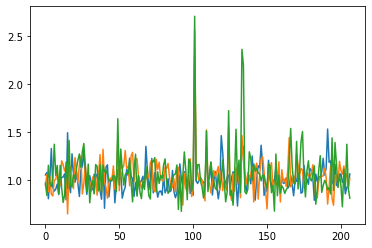

In [10]:
node_to_plot = 101
model = 0

node_id = trainer.models[model].fcgaga_layers[0].node_id_em(np.arange(207))
node_embeddings_dp = np.matmul(node_id, np.transpose(node_id, [1,0]))
node_embeddings_dp = tf.math.exp(10*node_embeddings_dp) 
plt.plot(node_embeddings_dp[node_to_plot])

node_id2 = trainer.models[model].fcgaga_layers[1].node_id_em(np.arange(207))
node_embeddings_dp2 = np.matmul(node_id2, np.transpose(node_id2, [1,0]))
node_embeddings_dp2 = tf.math.exp(10*node_embeddings_dp2) 
plt.plot(node_embeddings_dp2[node_to_plot])

node_id3 = trainer.models[model].fcgaga_layers[2].node_id_em(np.arange(207))
node_embeddings_dp3 = np.matmul(node_id3, np.transpose(node_id3, [1,0]))
node_embeddings_dp3 = tf.math.exp(10*node_embeddings_dp3) 
plt.plot(node_embeddings_dp3[node_to_plot])

(3.0, 3.5)

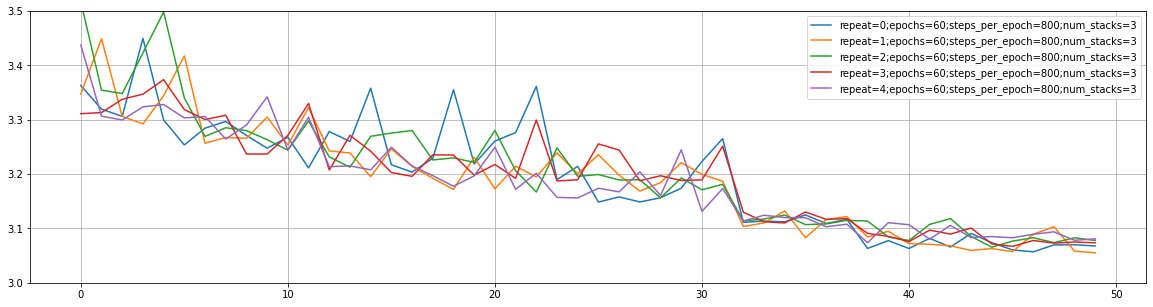

In [17]:
import fnmatch

filt = "*"

plt.figure(figsize=(20,5))
legend = []
for i, h in enumerate(trainer.history):
    if fnmatch.fnmatch(trainer.folder_names[i], filt):
        plt.plot(h['mae_test'][10:])
        legend.append(trainer.folder_names[i])

plt.legend(legend)
plt.grid(True)
plt.ylim([3.0, 3.5])


In [21]:
def insert_dict(d, k, v):
    previous = d.get(k, [])
    d[k] = previous + [v]
    return d

early_stop_mae_h_repeats = dict()
early_stop_mape_h_repeats = dict()
early_stop_rmse_h_repeats = dict()
early_stop_mae_h_ave = dict()
early_stop_mape_h_ave = dict()
early_stop_rmse_h_ave = dict()
for i, h in enumerate(trainer.history):
    early_stop_idx = np.argmin(h['mae_val'])
    early_stop_mae = np.round(h['mae_test'][early_stop_idx], decimals=3)
    print(f"Early stop test error model {trainer.folder_names[i]}:", "Avg MAE", early_stop_mae)
    for horizon in range(3, hyperparams.horizon+1, 3):

        early_stop_mae_h_repeats = insert_dict(early_stop_mae_h_repeats, k=horizon, v=h[f'mae_test_h{horizon}'][early_stop_idx])
        early_stop_mape_h_repeats = insert_dict(early_stop_mape_h_repeats, k=horizon, v=h[f'mape_test_h{horizon}'][early_stop_idx])
        early_stop_rmse_h_repeats = insert_dict(early_stop_rmse_h_repeats, k=horizon, v=h[f'rmse_test_h{horizon}'][early_stop_idx])
        
        print(f"Horizon {horizon} MAE:", np.round(early_stop_mae_h_repeats[horizon][-1], decimals=2), 
              f"Horizon {horizon} MAPE:", np.round(early_stop_mape_h_repeats[horizon][-1], decimals=2), 
              f"Horizon {horizon} RMSE:", np.round(early_stop_rmse_h_repeats[horizon][-1], decimals=2))

    for horizon in range(3, hyperparams.horizon+1, 3):
        early_stop_mae_h_ave[horizon] = np.round(np.mean(early_stop_mae_h_repeats[horizon]), decimals=2)
        early_stop_mape_h_ave[horizon] = np.round(np.mean(early_stop_mape_h_repeats[horizon]), decimals=2)
        early_stop_rmse_h_ave[horizon] = np.round(np.mean(early_stop_rmse_h_repeats[horizon]), decimals=2)

print()
print("Average MAE:", early_stop_mae_h_ave)
print("Average MAPE:", early_stop_mape_h_ave)
print("Average RMSE:", early_stop_rmse_h_ave)


Early stop test error model repeat=0;epochs=60;steps_per_epoch=800;num_stacks=3: Avg MAE 3.057
Horizon 3 MAE: 2.74 Horizon 3 MAPE: 7.24 Horizon 3 RMSE: 5.33
Horizon 6 MAE: 3.09 Horizon 6 MAPE: 8.53 Horizon 6 RMSE: 6.3
Horizon 9 MAE: 3.32 Horizon 9 MAPE: 9.35 Horizon 9 RMSE: 6.85
Horizon 12 MAE: 3.51 Horizon 12 MAPE: 9.97 Horizon 12 RMSE: 7.29
Early stop test error model repeat=1;epochs=60;steps_per_epoch=800;num_stacks=3: Avg MAE 3.058
Horizon 3 MAE: 2.74 Horizon 3 MAPE: 7.12 Horizon 3 RMSE: 5.29
Horizon 6 MAE: 3.09 Horizon 6 MAPE: 8.4 Horizon 6 RMSE: 6.28
Horizon 9 MAE: 3.33 Horizon 9 MAPE: 9.26 Horizon 9 RMSE: 6.89
Horizon 12 MAE: 3.51 Horizon 12 MAPE: 9.91 Horizon 12 RMSE: 7.31
Early stop test error model repeat=2;epochs=60;steps_per_epoch=800;num_stacks=3: Avg MAE 3.065
Horizon 3 MAE: 2.75 Horizon 3 MAPE: 7.17 Horizon 3 RMSE: 5.33
Horizon 6 MAE: 3.1 Horizon 6 MAPE: 8.45 Horizon 6 RMSE: 6.3
Horizon 9 MAE: 3.33 Horizon 9 MAPE: 9.33 Horizon 9 RMSE: 6.87
Horizon 12 MAE: 3.51 Horizon 12